# Start H2O

Import the h2o Python module and H2OAutoML class and initialize a local H2O cluster.


In [2]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_172"; Java(TM) SE Runtime Environment (build 1.8.0_172-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.172-b11, mixed mode)
  Starting server from /Users/me/code/github-repos/automl-fall-school-2022/venv/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/gj/cm0k4b_s42j30zs376cq_5hh0000gn/T/tmpz_7yybre
  JVM stdout: /var/folders/gj/cm0k4b_s42j30zs376cq_5hh0000gn/T/tmpz_7yybre/h2o_me_started_from_python.out
  JVM stderr: /var/folders/gj/cm0k4b_s42j30zs376cq_5hh0000gn/T/tmpz_7yybre/h2o_me_started_from_python.err
  Server is running at http://127.0.0.1:54325
Connecting to H2O server at http://127.0.0.1:54325 ... successful.


H2O_cluster_uptime:,12 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,20 days
H2O_cluster_name:,H2O_from_python_me_agjp2u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


# Load Data

For the AutoML binary classification demo, we use a subset of the [Product Backorders](https://www.kaggle.com/tiredgeek/predict-bo-trial/data) dataset. The goal here is to predict whether or not a product will be put on backorder status, given a number of product metrics such as current inventory, transit time, demand forecasts and prior sales.

In [3]:
# Use local data file or download from GitHub
import os
data_path = "data/product_backorders.csv"
if os.path.isfile(data_path) is False:
  data_path = "https://github.com/ledell/automl-fall-school-2022/raw/main/data/product_backorders.csv"


# Load data into H2O
df = h2o.import_file(data_path)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
df.describe()

Rows:19053
Cols:23

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
type,int,int,int,int,int,int,int,int,int,int,int,int,enum,int,real,real,int,enum,enum,enum,enum,enum,enum
mins,1111620.0,-1440.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,-99.0,-99.0,0.0,,,,,,
mean,2059552.760562641,376.36702881435997,7.706036161335188,48.27234556237863,182.9108276911772,344.7398309977431,497.79242114102766,56.11887891670601,168.53445651603428,333.53219965359784,504.25539285151945,48.84070750013119,,2.3114995013908577,-6.5198336220017845,-6.05393533826694,0.8917755734005144,,,,,,
maxs,3284775.0,730722.0,52.0,170920.0,479808.0,967776.0,1418208.0,186451.0,550609.0,1136154.0,1759152.0,85584.0,,13824.0,1.0,1.0,1440.0,,,,,,
sigma,663337.6456498681,7002.071628662684,6.7786650721241895,1465.9992102068286,4304.865591970627,8406.062155159249,12180.570042918363,1544.2177775482571,4581.340080221506,9294.566153218984,14184.14539565362,968.7738680675267,,110.24106014611976,25.975138766871872,25.18449715003253,23.033345417338797,,,,,,
zeros,0,1858,121,15432,12118,11136,10604,10278,8022,6864,6231,9909,,18601,474,401,18585,,,,,,
missing,0,0,1078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1113121.0,0.0,8.0,1.0,6.0,6.0,6.0,0.0,4.0,9.0,12.0,0.0,No,1.0,0.9,0.89,0.0,No,No,No,Yes,No,Yes
1,1113268.0,0.0,8.0,0.0,2.0,3.0,4.0,1.0,2.0,3.0,3.0,0.0,No,0.0,0.96,0.97,0.0,No,No,No,Yes,No,Yes
2,1113874.0,20.0,2.0,0.0,45.0,99.0,153.0,16.0,42.0,80.0,111.0,10.0,No,0.0,0.81,0.88,0.0,No,No,No,Yes,No,Yes


We will notice that the response column, `"went_on_backorder"`, is already encoded as "enum", so there's nothing we need to do here. If it were encoded as a 0/1 "int", then we'd have to convert the column as follows: `df[y] = df[y].asfactor()`

Next, let's identify the response & predictor columns by saving them as `x` and `y`. The `"sku"` column is a unique identifier so we'll want to remove that from the set of our predictors.

In [5]:
y = "went_on_backorder"
x = df.columns
x.remove(y)
x.remove("sku")

In [6]:
df.shape

(19053, 23)

# Run AutoML

Run AutoML, stopping after 10 models. The `max_models` argument specifies the number of individual (or "base") models, and does not include the ensemble models that are trained at subsequent stages of the modeling process and at the end.

In [7]:
aml = H2OAutoML(max_models = 10, seed = 1)
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20221010_63435

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.029819638898450643
RMSE: 0.17268363818975624
LogLoss: 0.10776110154602234
AUC: 0.9847325803092505
AUCPR: 0.922971552611131
Gini: 0.969465160618501
Null degrees of freedom: 10047
Residual degrees of freedom: 10038
Null deviance: 7382.805436218141
Residual deviance: 2165.567096668865
AIC: 2185.567096668865

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4110276006903641
       No    Yes    Error    Rate
-----  ----  -----  -------  ---------------
No     8661  179    0.0202   (179.0/8840.0)
Yes    209   999    0.173    (209.0/1208.0)
Total  8870  1178   0.0386   (388.0/10048.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.411028     0.837385  183
max f2                       0.189149     0.87123   259
max f0point5                 0.578991     0.881759  136
max accuracy                 0.479201     0.962182  163
max precision                0.986238     1         0
max recall                   0.00598772   1         386
max specificity              0.986238     1         0
max absolute_mcc             0.411028     0.815563  183
max min_per_class_accuracy   0.190831     0.937104  258
max mean_per_class_accuracy  0.189149     0.939296  259
max tns                      0.986238     8840      0
max fns                      0.986238     1205      0
max fps                      0.000423107  8840      399
max tps                      0.00598772   1208      386
max tnr                      0.986238     1         0
max fnr                      0.986238     0.997517  0
max fpr                      0.000423107  1         399
max tpr                      0.00598772   1         386

Gains/Lift Table: Avg response rate: 12.02 %, avg score: 12.04 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100518                   0.947983           8.31788    8.31788            1                0.964572    1                           0.964572            0.0836093       0.0836093                  731.788   731.788            0.0836093
2        0.020004                    0.923823           8.31788    8.31788            1                0.936876    1                           0.950793            0.0827815       0.166391                   731.788   731.788            0.166391
3        0.0300557                   0.89583            8.31788    8.31788            1                0.91054     1                           0.937331            0.0836093       0.25                       731.788   731.788            0.25
4        0.040008                    0.859131           8.2347     8.29719            0.99             0.877732    0.997512                    0.922505            0.0819536       0.331954                   723.47    729.719            0.331841
5        0.0500597                   0.818917           8.15317    8.26827            0.980198         0.841109    0.994036                    0.906161            0.0819536       0.413907                   715.317   726.827            0.413568
6        0.10002                     0.525231           6.8432     7.55644            0.822709         0.684904    0.908458                    0.795643            0.341887        0.755795         

# Leaderboard

Next, we will view the AutoML Leaderboard. Since we did not specify a specific frame (`leaderboard_frame`) in the `H2OAutoML.train()` method for scoring and ranking the models, the AutoML leaderboard uses cross-validation metrics (5-fold CV by default) to rank the models.

A default performance metric for each machine learning task (binary classification, multiclass classification, regression) is specified internally and the leaderboard will be sorted by that metric. In the case of binary classification, the default ranking metric is Area Under the ROC Curve (AUC). In the future, the user will be able to specify any of the H2O metrics so that different metrics can be used to generate rankings on the leaderboard.

The leader model is stored at `aml.leader` and the leaderboard is stored at `aml.leaderboard`.

In [9]:
lb = aml.leaderboard

Now we will view a snapshot of the top models. Here we should see the two Stacked Ensembles at or near the top of the leaderboard. Stacked Ensembles can almost always outperform a single model.

In [10]:
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20221010_63435,0.9521,0.168135,0.753793,0.144165,0.222846,0.0496602
StackedEnsemble_BestOfFamily_1_AutoML_1_20221010_63435,0.951981,0.168935,0.750911,0.137889,0.223316,0.0498701
GBM_4_AutoML_1_20221010_63435,0.948606,0.173961,0.736134,0.158272,0.226527,0.0513145
GBM_1_AutoML_1_20221010_63435,0.946849,0.175838,0.736278,0.161556,0.228859,0.0523764
XGBoost_3_AutoML_1_20221010_63435,0.946818,0.176144,0.7357,0.158623,0.22797,0.0519703
GBM_3_AutoML_1_20221010_63435,0.946027,0.177371,0.732411,0.177962,0.228546,0.0522332
GBM_2_AutoML_1_20221010_63435,0.944746,0.179901,0.72553,0.151993,0.230201,0.0529923
XGBoost_1_AutoML_1_20221010_63435,0.944324,0.18062,0.723453,0.159076,0.229847,0.0528299
XGBoost_2_AutoML_1_20221010_63435,0.943639,0.18085,0.732783,0.167392,0.229929,0.0528675
XRT_1_AutoML_1_20221010_63435,0.942144,0.21219,0.726515,0.159676,0.24522,0.060133


To view the entire leaderboard, specify the rows argument of the `head()` method as the total number of rows:

In [11]:
lb.head(rows=lb.nrows)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_1_AutoML_1_20221010_63435,0.9521,0.168135,0.753793,0.144165,0.222846,0.0496602
StackedEnsemble_BestOfFamily_1_AutoML_1_20221010_63435,0.951981,0.168935,0.750911,0.137889,0.223316,0.0498701
GBM_4_AutoML_1_20221010_63435,0.948606,0.173961,0.736134,0.158272,0.226527,0.0513145
GBM_1_AutoML_1_20221010_63435,0.946849,0.175838,0.736278,0.161556,0.228859,0.0523764
XGBoost_3_AutoML_1_20221010_63435,0.946818,0.176144,0.7357,0.158623,0.22797,0.0519703
GBM_3_AutoML_1_20221010_63435,0.946027,0.177371,0.732411,0.177962,0.228546,0.0522332
GBM_2_AutoML_1_20221010_63435,0.944746,0.179901,0.72553,0.151993,0.230201,0.0529923
XGBoost_1_AutoML_1_20221010_63435,0.944324,0.18062,0.723453,0.159076,0.229847,0.0528299
XGBoost_2_AutoML_1_20221010_63435,0.943639,0.18085,0.732783,0.167392,0.229929,0.0528675
XRT_1_AutoML_1_20221010_63435,0.942144,0.21219,0.726515,0.159676,0.24522,0.060133


By default, the leaderboard will contain model metrics only.  If you want to see more metrics, such as training time or prediction speed, you can view the "extended leaderboard" as follows:

In [12]:
# Get leaderboard with all possible columns
lb = h2o.automl.get_leaderboard(aml, extra_columns = "ALL")
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20221010_63435,0.9521,0.168135,0.753793,0.144165,0.222846,0.0496602,8072,0.034761,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20221010_63435,0.951981,0.168935,0.750911,0.137889,0.223316,0.0498701,6259,0.017432,StackedEnsemble
GBM_4_AutoML_1_20221010_63435,0.948606,0.173961,0.736134,0.158272,0.226527,0.0513145,1289,0.007261,GBM
GBM_1_AutoML_1_20221010_63435,0.946849,0.175838,0.736278,0.161556,0.228859,0.0523764,2278,0.008969,GBM
XGBoost_3_AutoML_1_20221010_63435,0.946818,0.176144,0.7357,0.158623,0.22797,0.0519703,1590,0.001437,XGBoost
GBM_3_AutoML_1_20221010_63435,0.946027,0.177371,0.732411,0.177962,0.228546,0.0522332,1212,0.006306,GBM
GBM_2_AutoML_1_20221010_63435,0.944746,0.179901,0.72553,0.151993,0.230201,0.0529923,1438,0.007112,GBM
XGBoost_1_AutoML_1_20221010_63435,0.944324,0.18062,0.723453,0.159076,0.229847,0.0528299,2130,0.001593,XGBoost
XGBoost_2_AutoML_1_20221010_63435,0.943639,0.18085,0.732783,0.167392,0.229929,0.0528675,2104,0.001565,XGBoost
XRT_1_AutoML_1_20221010_63435,0.942144,0.21219,0.726515,0.159676,0.24522,0.060133,1364,0.005656,DRF


# Compare models

Pareto front plot shows a [Pareto front](https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#pareto-front-plot) for any given dataframe, but it can be also used with AutoMLs and Grids. Pareto front is used to determine an optimal subset with regards to multiple criteria, currently our implementation supports 2 criteria/metrics. The pareto_front function returns a subset of the input frame/leaderboard and a plot depicting the Pareto front as shown below.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_1_AutoML_1_20221010_63435,0.9521,0.168135,0.753793,0.144165,0.222846,0.0496602,8072,0.034761,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20221010_63435,0.951981,0.168935,0.750911,0.137889,0.223316,0.0498701,6259,0.017432,StackedEnsemble
GBM_4_AutoML_1_20221010_63435,0.948606,0.173961,0.736134,0.158272,0.226527,0.0513145,1289,0.007261,GBM
XGBoost_3_AutoML_1_20221010_63435,0.946818,0.176144,0.7357,0.158623,0.22797,0.0519703,1590,0.001437,XGBoost
GLM_1_AutoML_1_20221010_63435,0.755494,0.335163,0.281558,0.288704,0.312871,0.0978884,599,0.001328,GLM


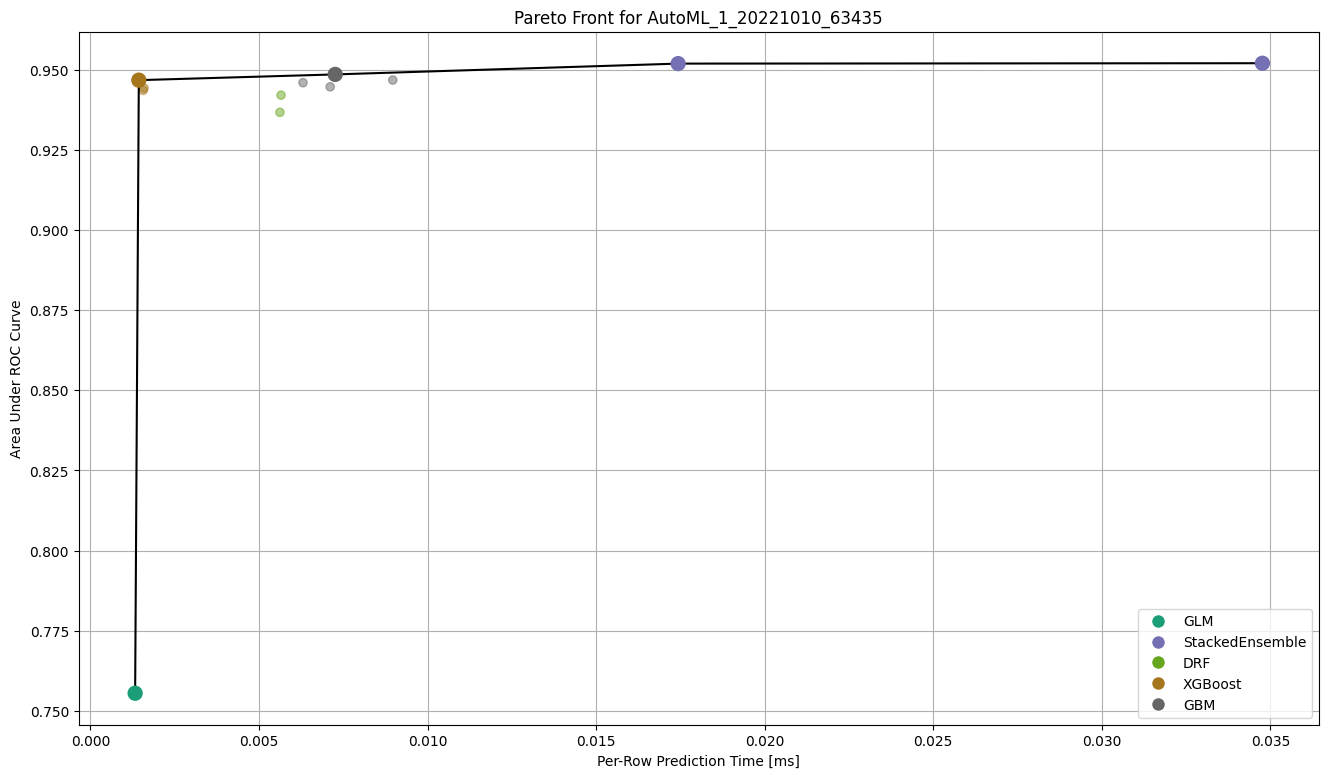

In [13]:
pf = aml.pareto_front()
pf.figure() # get the Pareto front plot
pf # H2OFrame containing the Pareto front subset of the leaderboard

# Examine models

To examine the trained models more closely, you can interact with the models, either by model ID, or a convenience function which can grab the best model of each model type (ranked by the default metric, or a metric of your choosing).

Get the best model, or the best model of a certain type:

In [14]:
# Get the best model using the metric
m = aml.leader
# this is equivalent to
m = aml.get_best_model()

# Get the best model using a non-default metric
m = aml.get_best_model(criterion="logloss")

# Get the best XGBoost model using default sort metric
xgb = aml.get_best_model(algorithm="xgboost")

# Get the best XGBoost model, ranked by logloss
xgb = aml.get_best_model(algorithm="xgboost", criterion="logloss")

In [ ]:
# Get a specific model by model ID (need t)
m = h2o.get_model("StackedEnsemble_AllModels_1_AutoML_1_20221010_63435")

Once you have retreived the model in R or Python, you can inspect the model parameters as follows:

In [ ]:
# View the parameters for the XGBoost model selected above
xgb.params.keys()

# Inspect individual parameter values
xgb.params['ntrees']

# Save Leader Model

There are two ways to save the leader model -- binary format and MOJO format. If you're taking your leader model to production, then we'd suggest the MOJO format since it's optimized for production use.

In [ ]:
h2o.save_model(aml.leader, path = "./product_backorders_model_bin")

In [8]:
aml.leader.download_mojo(path = "./")

'/Users/me/code/github-repos/automl-fall-school-2022/StackedEnsemble_AllModels_1_AutoML_1_20221010_63435.zip'